## Estimate effect of guides from on-target knock-down

In [1]:
# import rpy2.robjects.pandas2ri
# import rpy2.robjects.numpy2ri

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import yaml
from scipy import stats
from statsmodels.stats.multitest import multipletests
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../1_preprocess/'))
sys.path.append(os.path.abspath('../'))
from qc_plots import calculate_perturbed_gene_expression, test_knockdown_simple
from utils import feature_selection
from preprocess import _convert_oak_path

In [3]:
# Read config
experiment_name = 'CD4iR1_Psomagen'
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

config = config[experiment_name]
datadir = _convert_oak_path(config['datadir'])
sample_metadata_csv = _convert_oak_path(config['sample_metadata'])

sample_metadata = pd.read_csv(sample_metadata_csv, index_col=0)
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)

In [4]:
sample_metadata

,10xrun_id,cell_sample_id,donor_id,culture_condition,library_id,library_prep_kit,probe_hyb_loading,GEM_loading,sequencing_platform
0,CD4i_R1,CD4i_R1_D1_Rest,CE0008162,Rest,CD4i_R1_D1_Rest_CD4i_R1_Ultima,GEMX_flex_v2,"2M cells/probe, 40uL GEX probe, BC001-004, CRI...",1M cells/GEM,Ultima
1,CD4i_R1,CD4i_R1_D2_Rest,CE0010866,Rest,CD4i_R1_D2_Rest_CD4i_R1_Ultima,GEMX_flex_v2,"2M cells/probe, 40uL GEX probe, BC005-008, CRI...",1M cells/GEM,Ultima
2,CD4i_R1,CD4i_R1_D1_Stim8hr,CE0008162,Stim8hr,CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima,GEMX_flex_v2,"2M cells/probe, 40uL GEX probe, BC009-012, CRI...",1M cells/GEM,Ultima
3,CD4i_R1,CD4i_R1_D2_Stim8hr,CE0010866,Stim8hr,CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima,GEMX_flex_v2,"2M cells/probe, 40uL GEX probe, BC013-016, CRI...",1M cells/GEM,Ultima


In [5]:
if config['lane_ids'] is not None:
    all_lanes = config['lane_ids']
all_library_ids = sample_metadata['library_id'].tolist()

# Create dictionary to store samples by culture condition
samples_by_condition = {}
for condition in sample_metadata['culture_condition'].unique():
    samples_by_condition[condition] = []
    # Get library IDs for this condition
    condition_libraries = sample_metadata[sample_metadata['culture_condition'] == condition]['library_id']
    # Add samples for each library and lane
    for library_id in condition_libraries:
        for lane_id in all_lanes:
            samples_by_condition[condition].append(f"{library_id}.{lane_id}")

len(samples_by_condition['Rest'])

46

In [6]:
# Initialize empty dataframes to store results for all samples
guide_sums_df = pd.DataFrame()
guide_sums_sq_df = pd.DataFrame()
n_cells_guide_df = pd.DataFrame()
ntc_sums_df = pd.DataFrame()  
ntc_sums_sq_df = pd.DataFrame()  

# Process each sample
for sample_id in tqdm(samples_by_condition['Rest'], desc="Processing Rest samples"):
    f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    adata = anndata.experimental.read_lazy(f)
    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()

    targeting_mask = adata.obs['guide_type'] == 'targeting'
    cell2guide = pd.get_dummies(adata[targeting_mask].obs['guide_id']).astype(int)
    target_gene_values = adata[targeting_mask].obs['target_lognorm_expr'].values

    # Calculate statistics for this sample
    sample_guide_sums = pd.DataFrame(
        target_gene_values.reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_guide_sums_sq = pd.DataFrame(
        (target_gene_values ** 2).reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_n_cells = pd.DataFrame(
        cell2guide.sum(axis=0),
        index=cell2guide.columns,
        columns=[sample_id]
    )

    sample_ntc_sums = pd.DataFrame(
        adata.var['sum_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums_sq = pd.DataFrame(
        adata.var['sum_sq_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums.loc['n_ntc_cells'] = adata.uns['n_ntc']

    # Concatenate with existing results
    guide_sums_df = pd.concat([guide_sums_df, sample_guide_sums], axis=1)
    guide_sums_sq_df = pd.concat([guide_sums_sq_df, sample_guide_sums_sq], axis=1)
    n_cells_guide_df = pd.concat([n_cells_guide_df, sample_n_cells], axis=1)
    ntc_sums_df = pd.concat([ntc_sums_df, sample_ntc_sums], axis=1)  
    ntc_sums_sq_df = pd.concat([ntc_sums_sq_df, sample_ntc_sums_sq], axis=1)  

Processing Rest samples:   0%|          | 0/46 [00:00<?, ?it/s]

In [7]:
# Gest summary stats for each guide
total_guide_sums = guide_sums_df.fillna(0).sum(1)
total_guide_sums_sq = guide_sums_sq_df.fillna(0).sum(1)
total_guide_n = n_cells_guide_df.fillna(0).sum(1)
guide_mean_expr = total_guide_sums / total_guide_n
guide_std_expr = np.sqrt((total_guide_sums_sq - total_guide_sums**2 / total_guide_n) / (total_guide_n - 1))
guide_std_expr = guide_std_expr.fillna(100) # cases with one cell with guide

# Get summary stats for expression in NTCs
total_ntc_sums = ntc_sums_df.drop('n_ntc_cells').fillna(0).sum(1) 
total_ntc_sums_sq = ntc_sums_sq_df.fillna(0).sum(1) 
total_ntc_n = ntc_sums_df.loc['n_ntc_cells'].sum()
ntc_mean_expr = total_ntc_sums / total_ntc_n
ntc_std_expr = np.sqrt((total_ntc_sums_sq - total_ntc_sums**2 / total_ntc_n) / (total_ntc_n - 1))
ntc_std_expr = ntc_std_expr.fillna(100) # cases with one cell with guide

perturbed_genes = sgrna_library_metadata.set_index('sgrna_id').loc[guide_mean_expr.index]['perturbed_gene_id'].values
ntc_mean_expr = ntc_mean_expr.reindex(perturbed_genes, fill_value=0)
ntc_mean_expr.index = guide_mean_expr.index
ntc_std_expr = ntc_std_expr.reindex(perturbed_genes, fill_value=0)
ntc_std_expr.index = guide_mean_expr.index

ttest_df = pd.concat([guide_mean_expr, guide_std_expr, total_guide_n, ntc_mean_expr, ntc_std_expr], axis=1, 
                     keys=['guide_mean_expr', 'guide_std_expr', 'guide_n', 'ntc_mean_expr', 'ntc_std_expr'])
ttest_df['ntc_n'] = total_ntc_n

# Calculate Welch's t-test for each row
t_stats = []
p_values = []
for _, row in ttest_df.iterrows():
    t_stat, p_value = stats.ttest_ind_from_stats(
        row['guide_mean_expr'], row['guide_std_expr'], row['guide_n'],
        row['ntc_mean_expr'], row['ntc_std_expr'], row['ntc_n'],  # Using std=1.0 for NTCs
        equal_var=False)
    t_stats.append(t_stat)
    p_values.append(p_value)

ttest_df['t_statistic'] = t_stats
ttest_df['p_value'] = p_values

# Compute Benjamini-Hochberg adjusted p-values
valid_pvals = ttest_df['p_value'].dropna()
_, adj_pvals, _, _ = multipletests(valid_pvals, method='fdr_bh')
ttest_df.loc[valid_pvals.index, 'adj_p_value'] = adj_pvals
ttest_df['signif_knockdown'] = (ttest_df['adj_p_value'] < 0.1) & (ttest_df['t_statistic'] < 0)
ttest_df['adj_p_value'] = np.where(ttest_df['adj_p_value'] < 1e-16, 1e-16, ttest_df['adj_p_value'])

# Save ttest_df for Rest condition
ttest_df_rest = ttest_df.copy()
ttest_df_rest.to_csv(f'{datadir}/{experiment_name}.guide_effect.Rest.csv')


In [ ]:
# Initialize empty dataframes to store results for all samples
guide_sums_df = pd.DataFrame()
guide_sums_sq_df = pd.DataFrame()
n_cells_guide_df = pd.DataFrame()
ntc_sums_df = pd.DataFrame()  
ntc_sums_sq_df = pd.DataFrame()  

# Process each sample
for sample_id in tqdm(samples_by_condition['Stim8hr'], desc="Processing Rest samples"):
    f = f'{datadir}/tmp/{sample_id}.scRNA.postQC.h5ad'
    adata = anndata.experimental.read_lazy(f)
    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()

    targeting_mask = adata.obs['guide_type'] == 'targeting'
    cell2guide = pd.get_dummies(adata[targeting_mask].obs['guide_id']).astype(int)
    target_gene_values = adata[targeting_mask].obs['target_lognorm_expr'].values

    # Calculate statistics for this sample
    sample_guide_sums = pd.DataFrame(
        target_gene_values.reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_guide_sums_sq = pd.DataFrame(
        (target_gene_values ** 2).reshape(1, -1).dot(cell2guide.values).flatten(),
        index=cell2guide.columns,
        columns=[sample_id]
    )
    
    sample_n_cells = pd.DataFrame(
        cell2guide.sum(axis=0),
        index=cell2guide.columns,
        columns=[sample_id]
    )

    sample_ntc_sums = pd.DataFrame(
        adata.var['sum_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums_sq = pd.DataFrame(
        adata.var['sum_sq_lognorm_expr_ntc'].values,
        index=adata.var_names,
        columns=[sample_id]
    )
    sample_ntc_sums.loc['n_ntc_cells'] = adata.uns['n_ntc']

    # Concatenate with existing results
    guide_sums_df = pd.concat([guide_sums_df, sample_guide_sums], axis=1)
    guide_sums_sq_df = pd.concat([guide_sums_sq_df, sample_guide_sums_sq], axis=1)
    n_cells_guide_df = pd.concat([n_cells_guide_df, sample_n_cells], axis=1)
    ntc_sums_df = pd.concat([ntc_sums_df, sample_ntc_sums], axis=1)  
    ntc_sums_sq_df = pd.concat([ntc_sums_sq_df, sample_ntc_sums_sq], axis=1)  

# Gest summary stats for each guide
total_guide_sums = guide_sums_df.fillna(0).sum(1)
total_guide_sums_sq = guide_sums_sq_df.fillna(0).sum(1)
total_guide_n = n_cells_guide_df.fillna(0).sum(1)
guide_mean_expr = total_guide_sums / total_guide_n
guide_std_expr = np.sqrt((total_guide_sums_sq - total_guide_sums**2 / total_guide_n) / (total_guide_n - 1))
guide_std_expr = guide_std_expr.fillna(100) # cases with one cell with guide

# Get summary stats for expression in NTCs
total_ntc_sums = ntc_sums_df.drop('n_ntc_cells').fillna(0).sum(1) 
total_ntc_sums_sq = ntc_sums_sq_df.fillna(0).sum(1) 
total_ntc_n = ntc_sums_df.loc['n_ntc_cells'].sum()
ntc_mean_expr = total_ntc_sums / total_ntc_n
ntc_std_expr = np.sqrt((total_ntc_sums_sq - total_ntc_sums**2 / total_ntc_n) / (total_ntc_n - 1))
ntc_std_expr = ntc_std_expr.fillna(100) # cases with one cell with guide

perturbed_genes = sgrna_library_metadata.set_index('sgrna_id').loc[guide_mean_expr.index]['perturbed_gene_id'].values
ntc_mean_expr = ntc_mean_expr.reindex(perturbed_genes, fill_value=0)
ntc_mean_expr.index = guide_mean_expr.index
ntc_std_expr = ntc_std_expr.reindex(perturbed_genes, fill_value=0)
ntc_std_expr.index = guide_mean_expr.index

ttest_df = pd.concat([guide_mean_expr, guide_std_expr, total_guide_n, ntc_mean_expr, ntc_std_expr], axis=1, 
                     keys=['guide_mean_expr', 'guide_std_expr', 'guide_n', 'ntc_mean_expr', 'ntc_std_expr'])
ttest_df['ntc_n'] = total_ntc_n

# Calculate Welch's t-test for each row
t_stats = []
p_values = []
for _, row in ttest_df.iterrows():
    t_stat, p_value = stats.ttest_ind_from_stats(
        row['guide_mean_expr'], row['guide_std_expr'], row['guide_n'],
        row['ntc_mean_expr'], row['ntc_std_expr'], row['ntc_n'],  # Using std=1.0 for NTCs
        equal_var=False)
    t_stats.append(t_stat)
    p_values.append(p_value)

ttest_df['t_statistic'] = t_stats
ttest_df['p_value'] = p_values

# Compute Benjamini-Hochberg adjusted p-values
valid_pvals = ttest_df['p_value'].dropna()
_, adj_pvals, _, _ = multipletests(valid_pvals, method='fdr_bh')
ttest_df.loc[valid_pvals.index, 'adj_p_value'] = adj_pvals
ttest_df['signif_knockdown'] = (ttest_df['adj_p_value'] < 0.1) & (ttest_df['t_statistic'] < 0)
ttest_df['adj_p_value'] = np.where(ttest_df['adj_p_value'] < 1e-16, 1e-16, ttest_df['adj_p_value'])

# Save ttest_df for Rest condition
ttest_df_rest = ttest_df.copy()
ttest_df_rest.to_csv(f'{datadir}/{experiment_name}.guide_effect.Stim8hr.csv')


Processing Rest samples:   0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
stim_ttest_df = pd.read_csv(f'{datadir}/{experiment_name}.guide_effect.Stim8hr.csv', index_col=0)
rest_ttest_df = pd.read_csv(f'{datadir}/{experiment_name}.guide_effect.Rest.csv', index_col=0)

print(rest_ttest_df.signif_knockdown.value_counts())
print(stim_ttest_df.signif_knockdown.value_counts())

stim_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[stim_ttest_df.index]['perturbed_gene_id']
rest_ttest_df['perturbed_gene_id'] = sgrna_library_metadata.set_index('sgrna_id').loc[rest_ttest_df.index]['perturbed_gene_id']

signif_knockdown
True     17994
False     5403
Name: count, dtype: int64
signif_knockdown
True     18676
False     5197
Name: count, dtype: int64


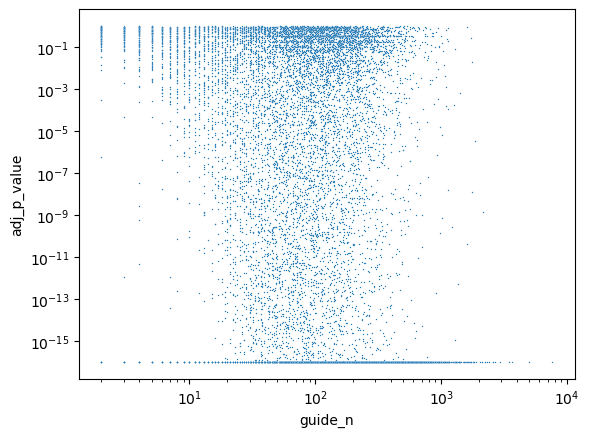

In [19]:
sns.scatterplot(data=stim_ttest_df, x='guide_n', y='adj_p_value', s=1);
plt.xscale('log')
plt.yscale('log')

In [60]:
rest_ttest_df

,guide_mean_expr,guide_std_expr,guide_n,ntc_mean_expr,ntc_std_expr,ntc_n,t_statistic,p_value,adj_p_value,signif_knockdown,perturbed_gene_id
A1BG-1,0.000000,0.000000,44.0,0.000000,0.000000,156848.0,NaN,NaN,NaN,False,ENSG00000121410
A1BG-2,0.000000,0.000000,234.0,0.000000,0.000000,156848.0,NaN,NaN,NaN,False,ENSG00000121410
A2M-2,0.000000,0.000000,122.0,0.000005,0.001796,156848.0,-1.000000,0.317312,3.487246e-01,False,ENSG00000175899
AAAS-1,0.251849,0.371910,112.0,0.281325,0.405174,156848.0,-0.838417,0.403595,4.373285e-01,False,ENSG00000094914
AAAS-2,0.000000,0.000000,11.0,0.281325,0.405174,156848.0,-274.983310,0.000000,1.000000e-16,True,ENSG00000094914
...,...,...,...,...,...,...,...,...,...,...,...
SLC26A4-2,0.000000,100.000000,1.0,0.005545,0.064077,156848.0,-0.000055,NaN,NaN,False,ENSG00000091137
SON-1,0.000000,100.000000,1.0,0.536656,0.505038,156848.0,-0.005367,NaN,NaN,False,ENSG00000159140
VMA21-2,0.361369,0.511053,2.0,0.845740,0.565333,156848.0,-1.340367,0.408054,4.419054e-01,False,ENSG00000160131
VMP1-1,0.690219,100.000000,1.0,1.034951,0.587439,156848.0,-0.003447,NaN,NaN,False,ENSG00000062716


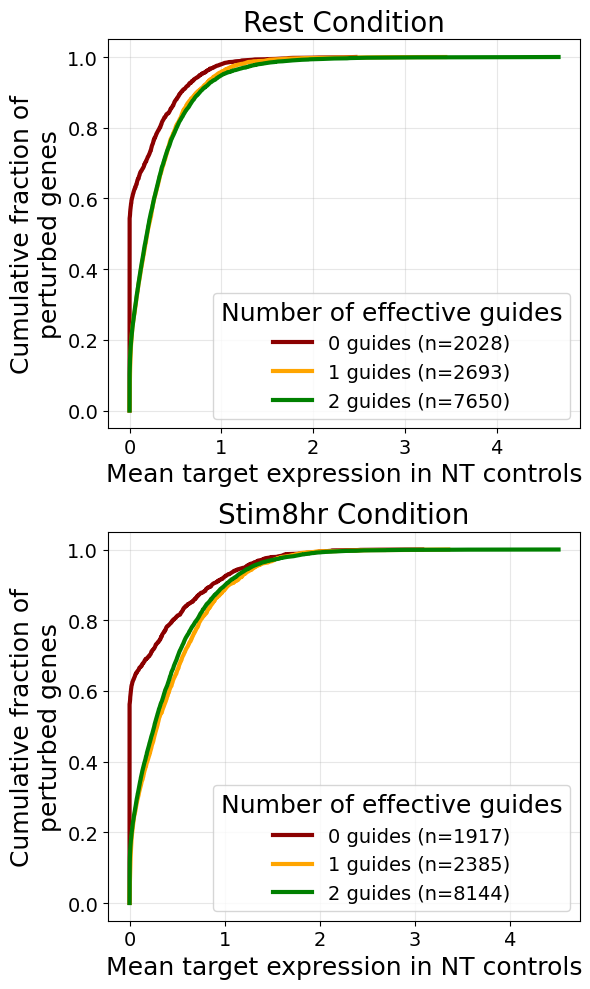

In [75]:
# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))

# Function to create the plot for a given dataframe and axis
def plot_cumulative_dist(df, ax, title):
    pl_df = df.groupby('perturbed_gene_id').agg({
        'ntc_mean_expr': 'mean',
        'signif_knockdown': 'sum'
    })
    pl_df['signif_knockdown'] = np.where(pl_df['signif_knockdown'] > 2, 2, pl_df['signif_knockdown'])

    colors = {2: 'green', 1: 'orange', 0: 'darkred'}
    for knockdown in sorted(pl_df['signif_knockdown'].unique()):
        subset = pl_df[pl_df['signif_knockdown'] == knockdown]
        x = np.sort(subset['ntc_mean_expr'])
        y = np.arange(1, len(x) + 1) / len(x)
        ax.plot(x, y, 
                label=f'{knockdown} guides (n={len(subset)})', 
                linewidth=3,
                color=colors[knockdown])

    ax.set_xlabel('Mean target expression in NT controls', fontsize=18)
    ax.set_ylabel('Cumulative fraction of\nperturbed genes', fontsize=18)
    ax.legend(title='Number of effective guides', fontsize=14, title_fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(title, fontsize=20)

# Plot for both conditions
plot_cumulative_dist(rest_ttest_df, ax1, 'Rest Condition')
plot_cumulative_dist(stim_ttest_df, ax2, 'Stim8hr Condition')

plt.tight_layout()

In [98]:
pl_df.value_counts('signif_knockdown')[0]/pl_df.value_counts('signif_knockdown').sum()

0.15402538968343243

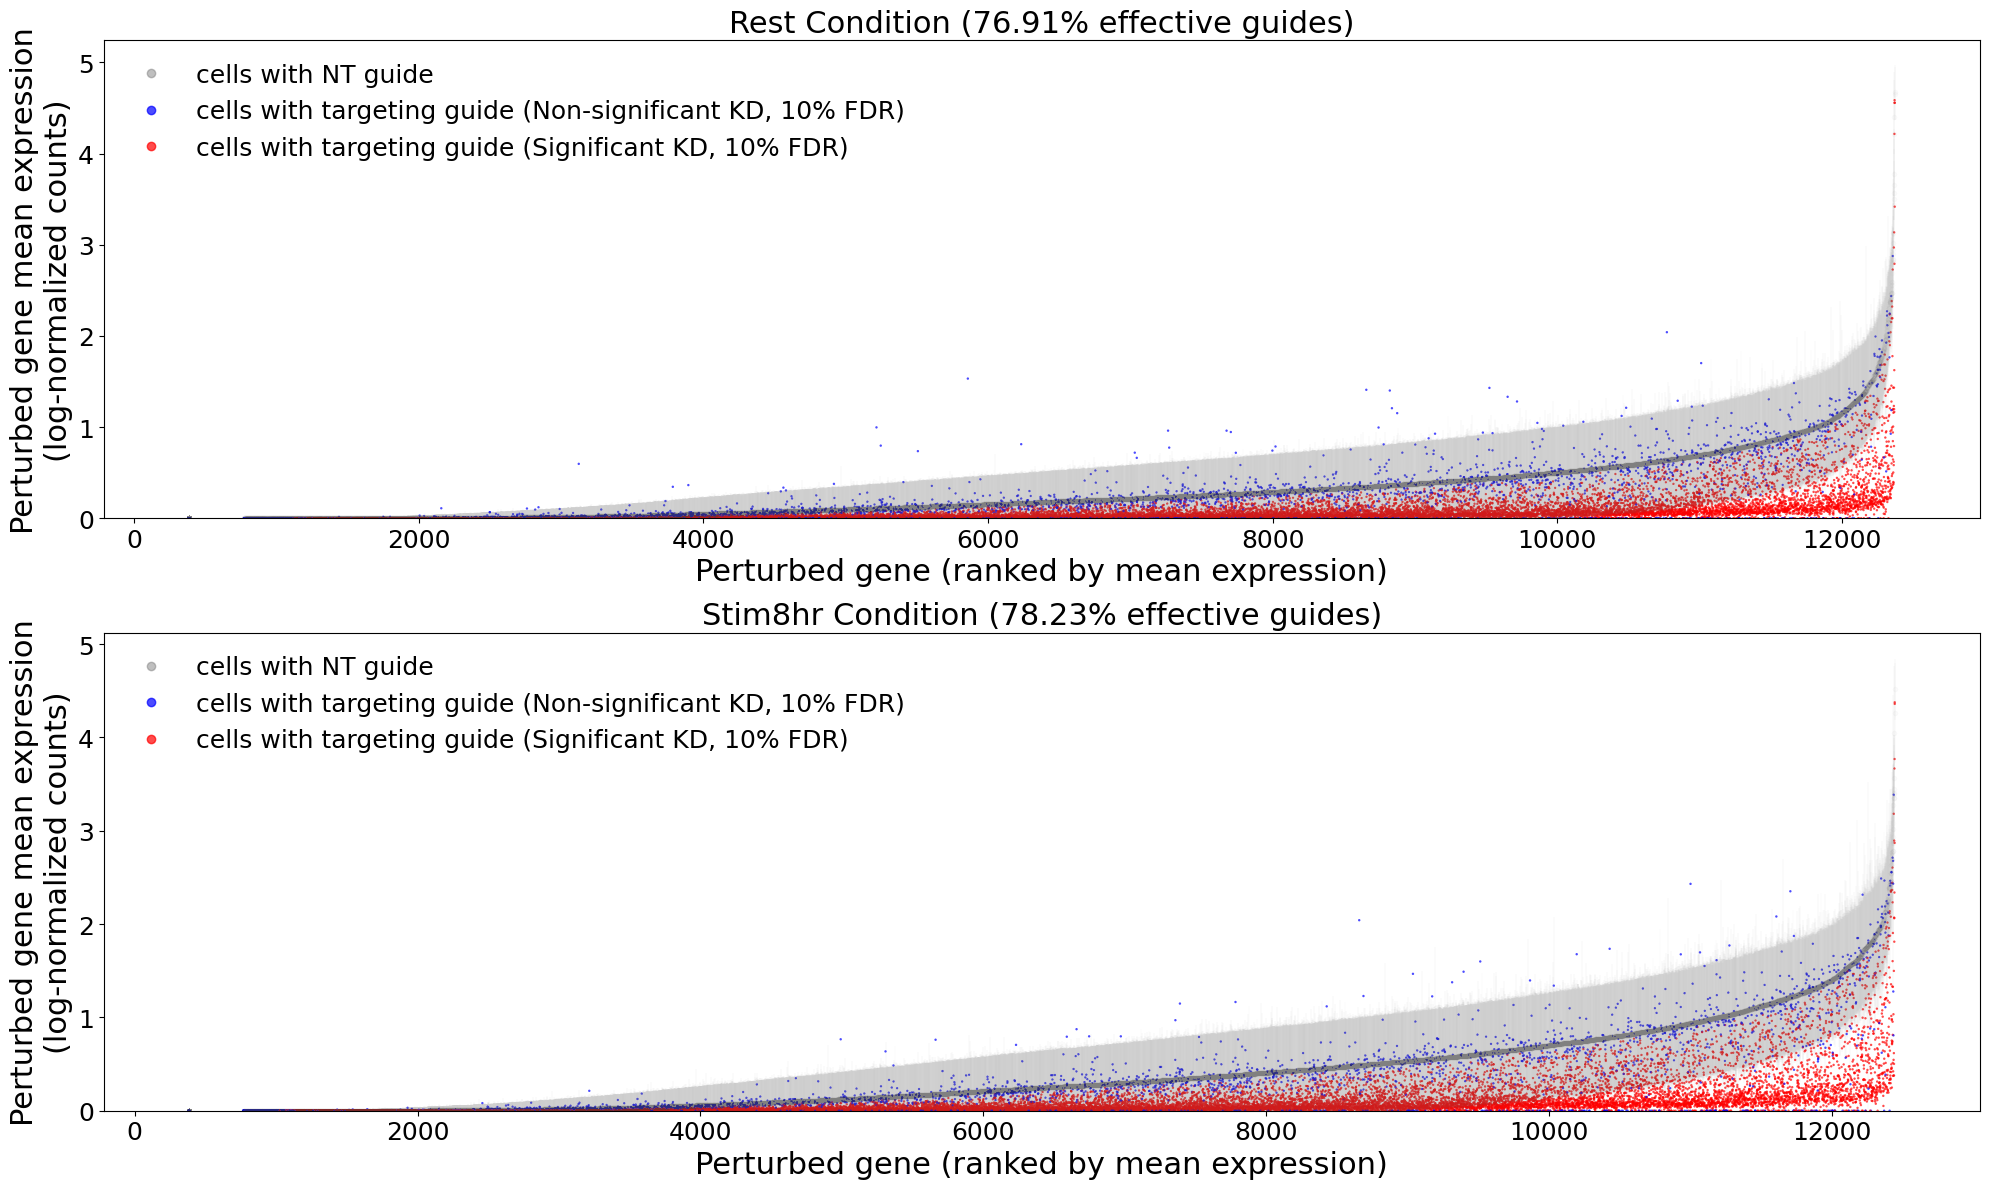

In [100]:
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,12))

# Function to create the plot for a given dataframe and axis
def plot_expression_rank(df, ax, title):
    # Get unique perturbed genes and their mean NTC expression
    gene_ntc_means = df.groupby('perturbed_gene_id')['ntc_mean_expr'].mean()
    # Rank the perturbed genes by their mean NTC expression
    gene_ranks = gene_ntc_means.rank()
    # Map the gene ranks back to the original dataframe
    df['rank'] = df['perturbed_gene_id'].map(gene_ranks)

    # Plot mean NTC expression with error bars
    ax.errorbar(df['rank'],
                df['ntc_mean_expr'], 
                yerr=df['ntc_std_expr'], 
                fmt='o',
                color='grey',
                markersize=3, 
                alpha=0.01,
                label='NT control cells')

    # Color points based on significance
    sns.scatterplot(
        data=df, 
        y='guide_mean_expr', 
        x='rank',
        s=3, 
        hue='signif_knockdown',
        palette={True: 'red', False: 'blue'},
        hue_order=[True, False],
        legend=False,
        alpha=0.7,
        linewidth=0,
        ax=ax)

    # Add legend
    ax.legend([plt.Line2D([0], [0], marker='o', color='grey', linestyle='', alpha=0.5),
               plt.Line2D([0], [0], marker='o', color='blue', linestyle='', alpha=0.7),
               plt.Line2D([0], [0], marker='o', color='red', linestyle='', alpha=0.7)],
              ['cells with NT guide', 'cells with targeting guide (Non-significant KD, 10% FDR)', 'cells with targeting guide (Significant KD, 10% FDR)'],
              loc='upper left', frameon=False, fontsize=18)
    ax.set_ylim(0)
    ax.set_xlabel('Perturbed gene (ranked by mean expression)', fontsize=22)
    ax.set_ylabel('Perturbed gene mean expression\n(log-normalized counts)', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title(title, fontsize=22)

# Plot for both conditions
plot_expression_rank(rest_ttest_df, ax1, f'Rest Condition ({np.round((rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])*100, 2)}% effective guides)')
plot_expression_rank(stim_ttest_df, ax2, f'Stim8hr Condition ({np.round((stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])*100, 2)}% effective guides)')

plt.tight_layout()

In [101]:
print(stim_ttest_df.signif_knockdown.value_counts()[True]/stim_ttest_df.shape[0])
print(rest_ttest_df.signif_knockdown.value_counts()[True]/rest_ttest_df.shape[0])

0.7823063712143425
0.7690729580715476


In [125]:
rest_ttest_df['high_confidence_no_effect_guides'] = (~rest_ttest_df['signif_knockdown']) & (rest_ttest_df.guide_n > 10) & (rest_ttest_df.ntc_mean_expr > 0)
stim_ttest_df['high_confidence_no_effect_guides'] = (~stim_ttest_df['signif_knockdown']) & (stim_ttest_df.guide_n > 10) & (stim_ttest_df.ntc_mean_expr > 0)

In [167]:
def plot_kd(mean_perturbed_gene_expr_df, top_n=100, figsize=(15,6), show_xlabels=True):
    # Group by guide_id instead of perturbed_gene
    guide_means = mean_perturbed_gene_expr_df.copy()

    # Select a subset of guides to plot (to avoid overcrowding)
    pl_df = guide_means.head(top_n)  # Take first 100 guides or adjust as needed
    pl_df
    plt.figure(figsize=figsize)
    # Plot mean NTC expression with error bars
    plt.errorbar(pl_df['guide_id'],
                pl_df['ntc_mean_expr'], 
                yerr=pl_df['ntc_std_expr'],
                fmt='o',
                color='grey',
                markersize=2,
                alpha=0.5,
                label='NT control cells')

    # Add stripplot of perturbed expression
    plt.errorbar(pl_df['guide_id'],
            pl_df['guide_mean_expr'],
            yerr=pl_df['guide_std_expr'],
            fmt='o',
            markersize=2,
            color='blue',
            alpha=0.5,
            label='Perturbed cells')

    if show_xlabels:
        plt.xticks(rotation=90)
    else:
        plt.xticks([])
    plt.ylim(0)
    plt.xlabel('Guide ID')
    plt.ylabel('Perturbed gene expression (log-normalized counts)')
    plt.legend(frameon=False)
    plt.tight_layout()

In [141]:
rest_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[rest_ttest_df.high_confidence_no_effect_guides.values]

,guide_id,guide_mean_expr,guide_std_expr,guide_n,ntc_mean_expr,ntc_std_expr,ntc_n,t_statistic,p_value,adj_p_value,signif_knockdown,perturbed_gene_id,rank,high_confidence_no_effect_guides
2,A2M-2,0.000000,0.000000,122.0,0.000005,0.001796,156848.0,-1.000000,0.317312,0.348725,False,ENSG00000175899,891.0,True
3,AAAS-1,0.251849,0.371910,112.0,0.281325,0.405174,156848.0,-0.838417,0.403595,0.437329,False,ENSG00000094914,7911.0,True
12,AARS2-1,0.160098,0.322080,91.0,0.157230,0.316060,156848.0,0.084912,0.932520,0.939794,False,ENSG00000124608,6084.0,True
13,AARS2-2,0.076745,0.297232,15.0,0.157230,0.316060,156848.0,-1.048678,0.312090,0.348725,False,ENSG00000124608,6084.0,True
14,AARSD1-2,0.161150,0.324264,303.0,0.157699,0.325619,156848.0,0.185094,0.853279,0.867928,False,ENSG00000266967,6092.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22897,RFWD3-1,0.221594,0.563472,14.0,0.282729,0.426820,156848.0,-0.405953,0.691380,0.718306,False,ENSG00000168411,7927.0,True
22904,TNS1-1,0.033273,0.179179,29.0,0.023209,0.137025,156848.0,0.302462,0.764535,0.786727,False,ENSG00000079308,3413.0,True
22956,RPN1-1,0.457664,0.419697,14.0,0.319220,0.420477,156848.0,1.234199,0.238971,0.270558,False,ENSG00000163902,8364.0,True
22994,POLR2A-1,0.893920,0.681892,14.0,0.755538,0.565592,156848.0,0.759304,0.461217,0.495476,False,ENSG00000181222,11219.0,True


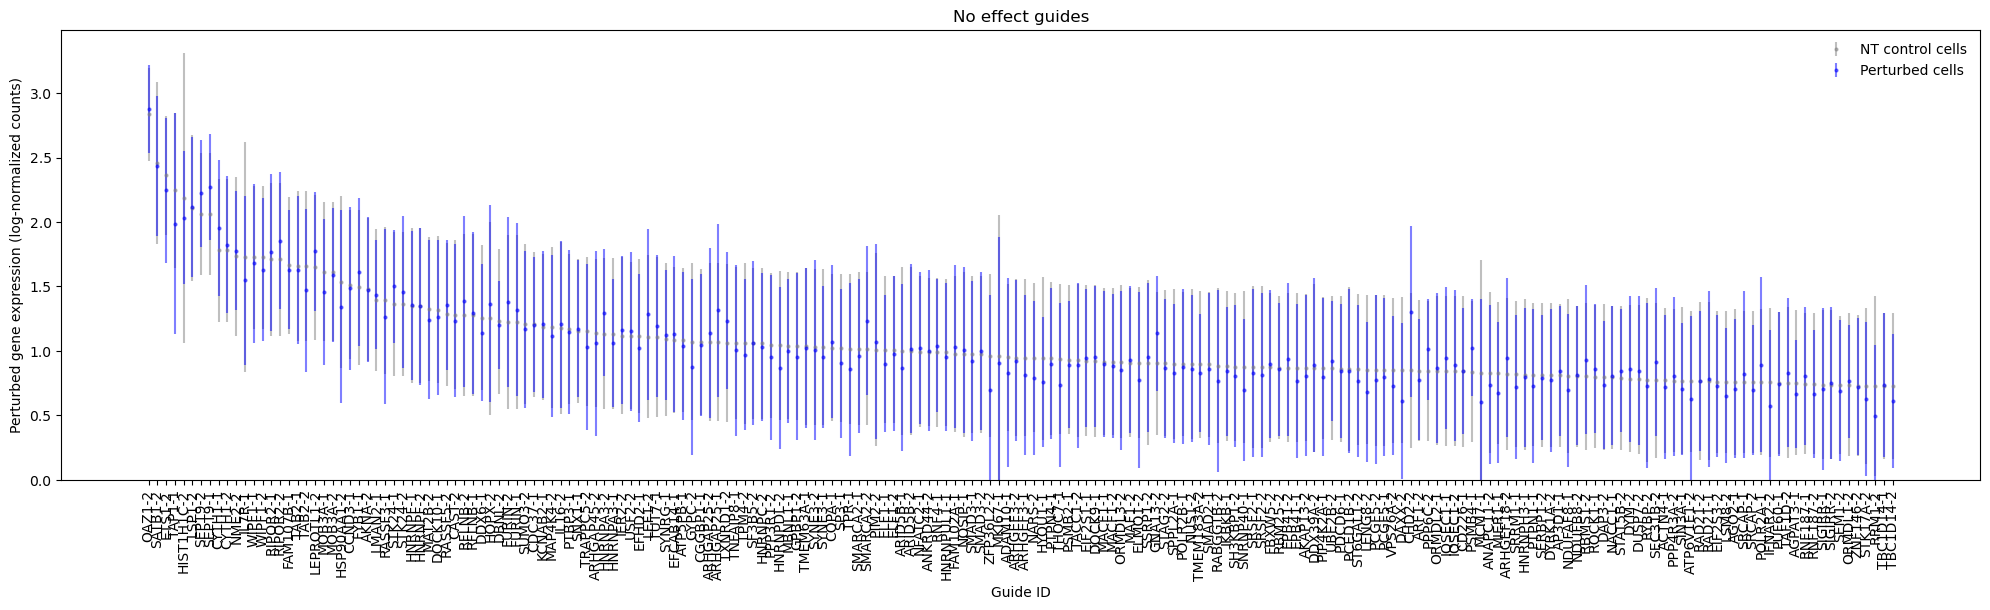

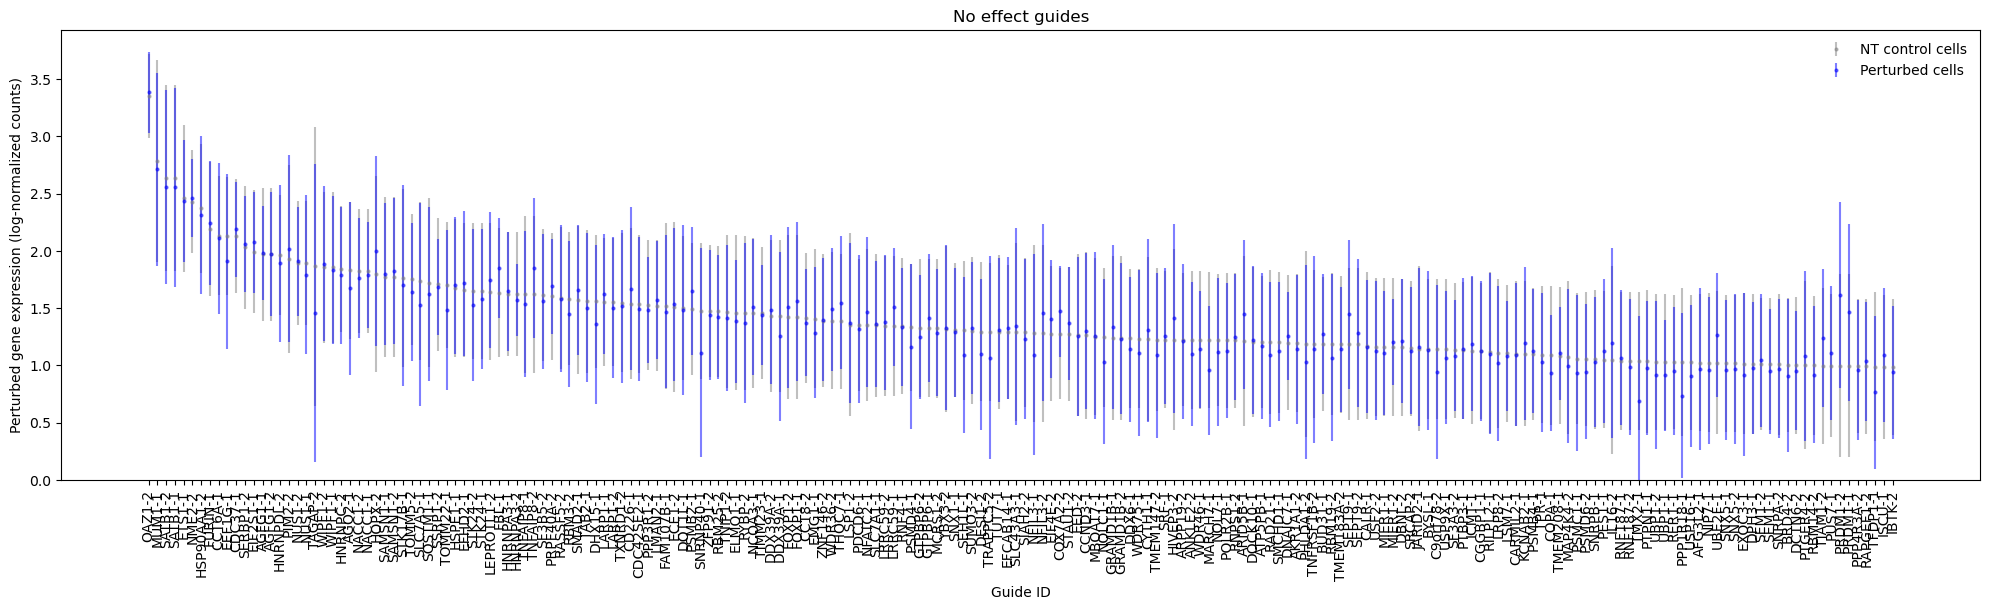

In [169]:
pl_df = rest_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[rest_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

pl_df = stim_ttest_df.reset_index().rename({'index':'guide_id'}, axis=1)[stim_ttest_df.high_confidence_no_effect_guides.values]
pl_df = pl_df.sort_values('ntc_mean_expr', ascending=False)
plot_kd(pl_df, top_n=200, figsize=(20,6))
plt.title('No effect guides')
plt.show()

### Save list of putative ineffective guides (across conditions)

In [163]:
no_effect_guides = np.intersect1d(rest_ttest_df.index[rest_ttest_df['high_confidence_no_effect_guides']], stim_ttest_df.index[stim_ttest_df['high_confidence_no_effect_guides']])
no_effect_guides = no_effect_guides.tolist()
print(len(no_effect_guides))

1476


In [164]:
# Save no_effect_guides to a text file
with open(os.path.join(datadir, 'no_effect_guides.txt'), 'w') as f:
    for guide in no_effect_guides:
        f.write(f"{guide}\n")


In [170]:
len(no_effect_guides)

1476

In [179]:
sgrna_library_metadata.set_index('sgrna_id').loc[no_effect_guides].perturbed_gene_id.value_counts() 

perturbed_gene_id
ENSG00000196535    3
ENSG00000198643    2
ENSG00000176165    2
ENSG00000198053    2
ENSG00000128610    2
                  ..
ENSG00000196305    1
ENSG00000005700    1
ENSG00000116237    1
ENSG00000159110    1
ENSG00000162378    1
Name: count, Length: 1206, dtype: int64